# Big Data for Public Policy

## Unsupervised Learning

## [Malka Guillot]()

## ETH Zürich | [860-0033-00L](https://malkipp.github.io/big_data_policy_2021/)

In [1]:
import gensim
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyLDAvis
import os
import seaborn as sns; sns.set()  # for plot styling
import wordcloud

from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from scipy.cluster import hierarchy

%matplotlib inline
plt.style.use('seaborn-white')

# Where to save the figures
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## Principal Component Analysis

**`USAarrests` data**

For each of the fifty states in the United States, the data set contains the number of arrests per 100, 000 residents for each of three crimes: `Assault` ,` Murder` ,and `Rape` . Other variable: `UrbanPop` (the percent of the population in each state living in urban areas).

In [2]:
import os
parent_path=os.path.dirname(os.getcwd()) # os.getcwd() fetchs the current path, 
data_path=os.path.join(parent_path, 'data')
df = pd.read_csv(os.path.join(data_path, 'USArrests.csv'), index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [3]:
df.mean()

Murder        7.788
Assault     170.760
UrbanPop     65.540
Rape         21.232
dtype: float64

### Pre-processing
PCA should be performed after standardizing each variable to have mean zero and standard deviation one.

In [4]:
X = pd.DataFrame(scale(df), index=df.index, columns=df.columns)

Text(0.5, 0, 'Murder')

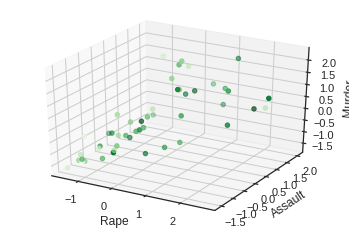

In [5]:
from mpl_toolkits import mplot3d
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
# Data for three-dimensional scattered points
ax.scatter3D(X['Rape'], X['Assault'], X['Murder'], c=X['UrbanPop'], cmap='Greens');
ax.set_xlabel('Rape')
ax.set_ylabel('Assault')
ax.set_zlabel('Murder')


### Fit PCA

In [6]:
# The loading vectors
pca_loadings = pd.DataFrame(PCA().fit(X).components_.T, index=df.columns, columns=['V1', 'V2', 'V3', 'V4'])
pca_loadings

,V1,V2,V3,V4
Murder,0.535899,0.418181,-0.341233,0.649228
Assault,0.583184,0.187986,-0.268148,-0.743407
UrbanPop,0.278191,-0.872806,-0.378016,0.133878
Rape,0.543432,-0.167319,0.817778,0.089024


In [7]:
# Fit the PCA model and transform X to get the principal components
pca = PCA()
df_plot = pd.DataFrame(pca.fit_transform(X), columns=['PC1', 'PC2', 'PC3', 'PC4'], index=X.index)
#df_plot

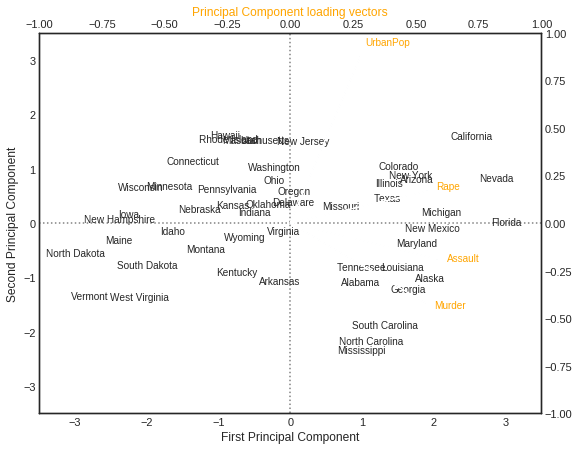

In [8]:
fig , ax1 = plt.subplots(figsize=(9,7))

ax1.set_xlim(-3.5,3.5)
ax1.set_ylim(-3.5,3.5)

# Plot Principal Components 1 and 2
for i in df_plot.index:
    ax1.annotate(i, (df_plot.PC1.loc[i], -df_plot.PC2.loc[i]), ha='center')

# Plot reference lines
ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

ax1.set_xlabel('First Principal Component')
ax1.set_ylabel('Second Principal Component')
    
# Plot Principal Component loading vectors, using a second y-axis.
ax2 = ax1.twinx().twiny() 

ax2.set_ylim(-1,1)
ax2.set_xlim(-1,1)
ax2.tick_params(axis='y', colors='orange')
ax2.set_xlabel('Principal Component loading vectors', color='orange')

# Plot labels for vectors. Variable 'a' is a small offset parameter to separate arrow tip and text.
a = 1.07  
for i in pca_loadings[['V1', 'V2']].index:
    ax2.annotate(i, (pca_loadings.V1.loc[i]*a, -pca_loadings.V2.loc[i]*a), color='orange')

# Plot vectors
ax2.arrow(0,0,pca_loadings.V1[0], -pca_loadings.V2[0])
ax2.arrow(0,0,pca_loadings.V1[1], -pca_loadings.V2[1])
ax2.arrow(0,0,pca_loadings.V1[2], -pca_loadings.V2[2])
ax2.arrow(0,0,pca_loadings.V1[3], -pca_loadings.V2[3]);

In [9]:
# Standard deviation of the four principal components
np.sqrt(pca.explained_variance_)

array([1.5908673 , 1.00496987, 0.6031915 , 0.4206774 ])

In [10]:
pca.explained_variance_

array([2.53085875, 1.00996444, 0.36383998, 0.17696948])

In [11]:
pca.explained_variance_ratio_

array([0.62006039, 0.24744129, 0.0891408 , 0.04335752])

### Choosing the number of components

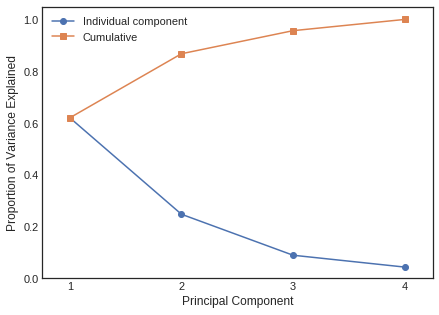

In [12]:
plt.figure(figsize=(7,5))

plt.plot([1,2,3,4], pca.explained_variance_ratio_, '-o', label='Individual component')
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s', label='Cumulative')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.legend(loc=2);

## Clustering Methods


### Generate a two-dimensional dataset containing four distinct blobs

/home/guillotm/.local/lib/python3.6/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


Saving figure blobs_diagram


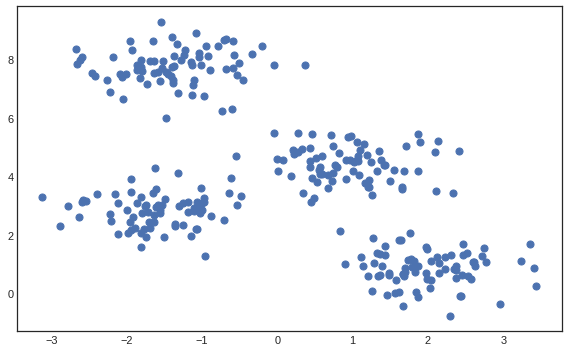

In [13]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], s=50);
save_fig("blobs_diagram")
plt.show()

### Means Clustering

In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
y_kmeans # Each instance was assigned to one of the 4 clusters:

array([3, 2, 1, 2, 3, 3, 0, 1, 2, 2, 0, 2, 1, 2, 3, 1, 1, 3, 0, 0, 3, 3,
       1, 0, 0, 1, 3, 1, 0, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 3, 1, 0, 1, 1,
       0, 0, 2, 0, 2, 3, 0, 3, 2, 3, 3, 0, 2, 0, 2, 3, 2, 1, 2, 0, 0, 0,
       2, 3, 2, 0, 1, 0, 2, 0, 0, 2, 0, 1, 3, 2, 3, 1, 3, 3, 2, 1, 3, 1,
       2, 2, 1, 3, 2, 0, 0, 1, 3, 3, 1, 0, 2, 3, 2, 3, 1, 3, 3, 1, 2, 1,
       0, 0, 3, 2, 3, 1, 2, 3, 3, 1, 0, 3, 0, 3, 3, 3, 3, 0, 3, 0, 2, 0,
       0, 3, 2, 0, 0, 2, 1, 2, 2, 0, 1, 0, 1, 0, 2, 1, 2, 2, 2, 1, 2, 1,
       3, 0, 2, 0, 3, 1, 2, 1, 1, 3, 1, 0, 0, 1, 3, 1, 1, 2, 3, 1, 0, 2,
       3, 3, 1, 0, 3, 1, 0, 0, 1, 1, 1, 1, 3, 2, 1, 0, 1, 1, 0, 0, 0, 1,
       0, 2, 1, 0, 3, 0, 1, 2, 0, 2, 1, 2, 1, 0, 1, 1, 2, 0, 0, 3, 3, 1,
       2, 3, 3, 0, 3, 0, 1, 2, 2, 1, 1, 2, 1, 3, 0, 1, 3, 0, 2, 0, 3, 1,
       3, 2, 2, 2, 2, 0, 0, 2, 1, 0, 3, 1, 0, 0, 0, 3, 3, 2, 1, 1, 0, 3,
       2, 0, 1, 2, 1, 3, 3, 0, 0, 1, 3, 3, 3, 1, 2, 2, 3, 3, 1, 3, 3, 3,
       2, 0, 2, 1, 3, 3, 2, 2, 2, 3, 3, 1, 2, 0], d

In [15]:
kmeans.cluster_centers_ # The 4 centroïds estimated

array([[-1.58438467,  2.83081263],
       [ 0.94973532,  4.41906906],
       [-1.37324398,  7.75368871],
       [ 1.98258281,  0.86771314]])

we can predict the labels of new instances:

In [16]:
X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(X_new)

array([0, 3, 0, 0], dtype=int32)

Visualize the results:

Saving figure blobs_diagram_4clusters


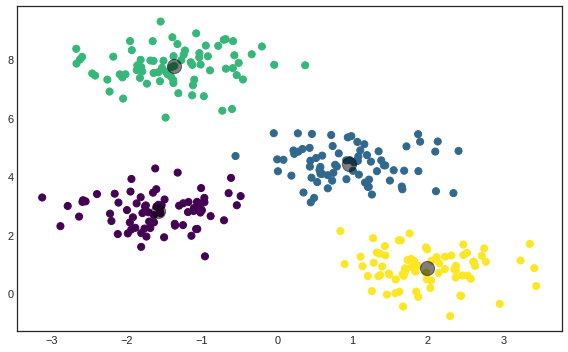

In [17]:
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
save_fig("blobs_diagram_4clusters")

Saving figure blobs_diagram_6clusters


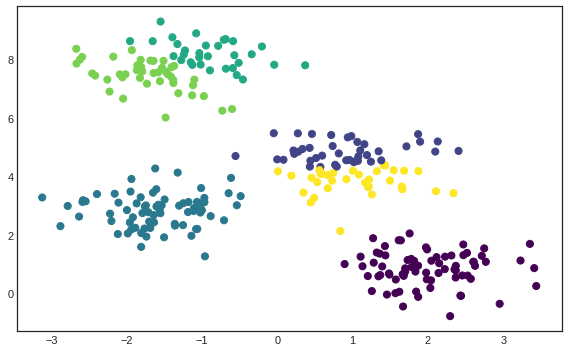

In [18]:
labels = KMeans(6, random_state=0).fit_predict(X)
plt.figure(figsize=(8, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='viridis');
save_fig("blobs_diagram_6clusters")

In [19]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

Saving figure voronoi_diagram


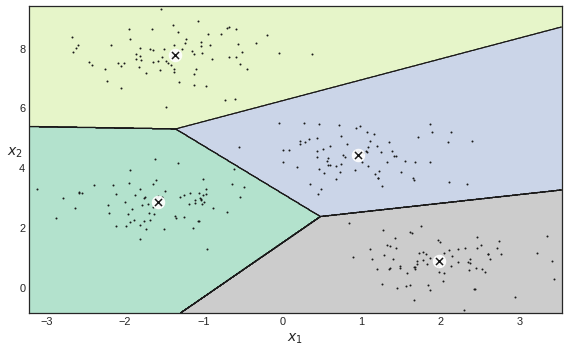

In [20]:
plt.figure(figsize=(8, 5))
plot_decision_boundaries(kmeans, X)
save_fig("voronoi_diagram")
plt.show()

Let's run the K-Means algorithm for 1, 2 and 3 iterations, to see how the centroids move around:

In [21]:
kmeans_iter1 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=4, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=4, n_init=1,
       random_state=1)

Saving figure kmeans_algorithm_diagram


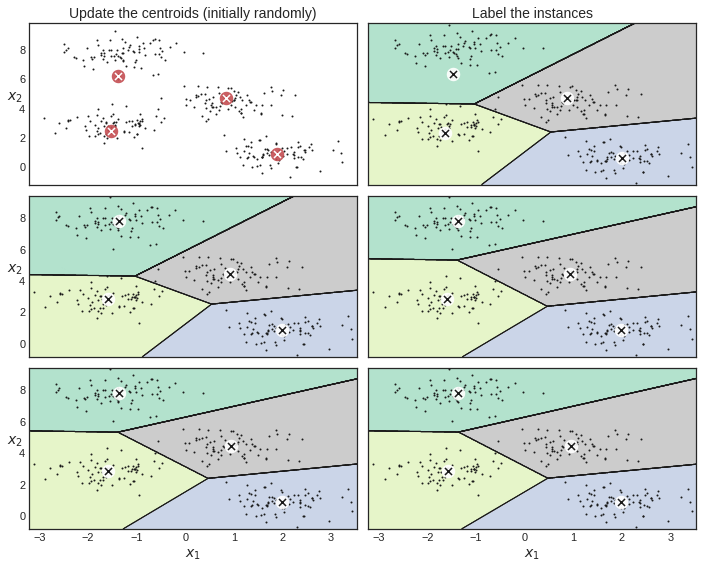

In [22]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

save_fig("kmeans_algorithm_diagram")
plt.show()

### Finding the optimal number of clusers

Saving figure inertia_vs_k_diagram


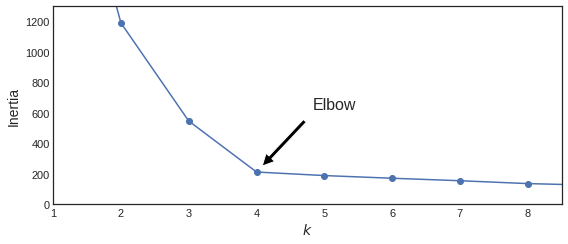

In [23]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]
plt.figure(figsize=(8, 3.5))
plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.annotate('Elbow',
             xy=(4, inertias[3]),
             xytext=(0.55, 0.55),
             textcoords='figure fraction',
             fontsize=16,
             arrowprops=dict(facecolor='black', shrink=0.1)
            )
plt.axis([1, 8.5, 0, 1300])
save_fig("inertia_vs_k_diagram")
plt.show()

In [24]:
from sklearn.metrics import silhouette_score
silhouette_score(X, kmeans.labels_)

0.6819938690643478

In [25]:
silhouette_scores = [silhouette_score(X, model.labels_)
                     for model in kmeans_per_k[1:]]

Saving figure silhouette_score_vs_k_diagram


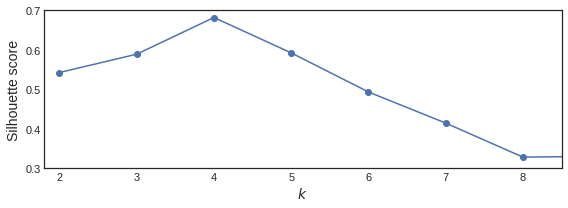

In [26]:
plt.figure(figsize=(8, 3))
plt.plot(range(2, 10), silhouette_scores, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Silhouette score", fontsize=14)
plt.axis([1.8, 8.5, 0.3, 0.7])
save_fig("silhouette_score_vs_k_diagram")
plt.show()

### Hierarchical Clustering
#### Fitting the model

In [27]:
from sklearn.cluster import AgglomerativeClustering
agglo = AgglomerativeClustering(n_clusters=5)
agglo.fit(X)

AgglomerativeClustering(n_clusters=5)

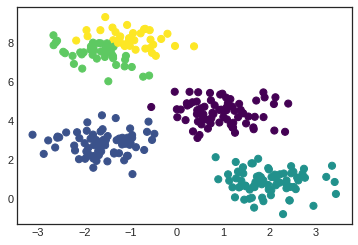

In [28]:
labels = agglo.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

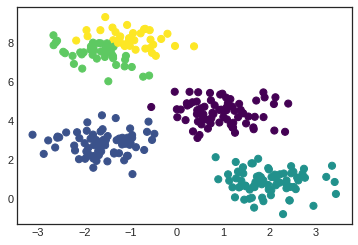

In [29]:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(X)
labels = agglo.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

#### Dendrogram

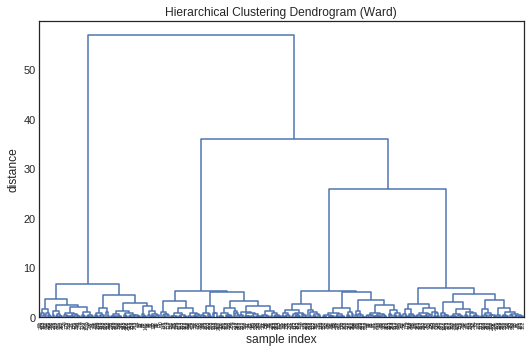

In [30]:
from scipy.cluster.hierarchy import dendrogram, linkage

linkage_matrix = linkage(X, 'ward')
figure = plt.figure(figsize=(7.5, 5))
dendrogram(
    linkage_matrix,
    color_threshold=0,
)
plt.title('Hierarchical Clustering Dendrogram (Ward)')
plt.xlabel('sample index')
plt.ylabel('distance')
plt.tight_layout()
plt.show()